In [1]:
import pandas_datareader as wb
from pandas_datareader import data
import yfinance as yf
import requests 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from lxml import html
import datetime
from datetime import datetime
import statsmodels.api as sm
from scipy.stats import norm
from tqdm.notebook import tqdm

In [2]:
def get_treasury_rate():
    
    url = 'https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield'
    r = requests.get(url)
    html = r.text

    soup = BeautifulSoup(html)
    table = soup.find('table', {"class": "t-chart"})
    rows = table.find_all('tr')
    data = []
    for row in rows[1:]:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele])

        result = pd.DataFrame(data, columns=['Date', '1 Mo', '2 Mo', '3 Mo', '6 Mo', '1 Yr', '2 Yr', '3 Yr', '5 Yr', '7 Yr', '10 Yr', '20 Yr', '30 Yr'])

    return(result)

def daily_price_df(equity_list, years_from_now = 5,end = datetime.today()):
    
    today = datetime.today()
    start = datetime.now().replace(today.year-years_from_now)
    stock_price_df = wb.DataReader(equity_list, data_source = 'yahoo', start = start, end = end)
    
    return stock_price_df

def return_df(close_price_df):
        
    return_df = close_price_df.pct_change().apply(lambda x: np.log(1+x))
    
    return return_df

def get_equity_info(company_list):
    
    """#input is a list of company symbols, return a dataframe of informtions regarding the company"""
    
    def process_table(company_info):
        concat_table=None
        for i in range(len(company_info.columns)):
            if i%2 == 0:
                curr = company_info[[i,i+1]].T
                curr = curr.reset_index(drop = True)
                curr.columns = curr.iloc[0]
                curr=curr.drop(0)
                if concat_table is None:
                    concat_table = curr
                else:
                    concat_table = pd.concat([concat_table,curr],axis = 1)
                    
        return concat_table
    
    return_table = None
    
    Error_name = []
    
    for company in tqdm(company_list):
        
        try:
            html = requests.get("https://finviz.com/quote.ashx?t="+company,headers = headers).text
            tables = pd.read_html(html)
            table = tables[5]
            
            if return_table is None:
                return_table = process_table(table)
            
            else:
                return_table = pd.concat([return_table,process_table(table)], axis = 0)
                
        except IndexError:
            Error_name.append(company)
            continue
        
    return_table.index = company_list
    return_table = return_table.replace('-',np.nan)
    
    if len(Error_name)!= 0:
        print(Error_name)
    
    return return_table

def port_simulation(stock_closed_df, freq = "D"):
    
    days_per_freq = {"D": 1, "W": 5, "M": 21, "Y": 250}
    
    pct_change_df = stock_closed_df.pct_change()
    period_pct_change = pct_change_df.resample(freq).mean()
    ind_er = period_pct_change.mean()
    return_df = pct_change_df.apply(lambda x: np.log(1+x))
    cov_matrix = return_df.cov()
    
    p_ret = [] 
    p_vol = [] 
    p_weights = [] 
    
    
    num_assets = len(stock_closed_df.columns)
    num_portfolios = 10000

    
    for portfolio in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights = weights/np.sum(weights)
        p_weights.append(weights)
        returns = np.dot(weights, ind_er)  
        p_ret.append(returns)
        var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
        sd = np.sqrt(var) 
        freq_sd = sd*np.sqrt(days_per_freq[freq]) 
        p_vol.append(freq_sd)
    
    data = {'Returns':p_ret, 'Volatility':p_vol}
 
    for counter, symbol in enumerate(stock_closed_df.columns.tolist()):
        data[symbol+' weight'] = [w[counter] for w in p_weights]
        portfolios  = pd.DataFrame(data)
        
    return portfolios



In [3]:
def FF_assign_label(index_comp_info):
        
        
    index_comp_info["bookToMarket"] = 1/index_comp_info["PB_ratio"]
    index_comp_info["Small_Big_Cap"] = index_comp_info["mkt_cap"].map(lambda x: "B" if x >= index_comp_info["mkt_cap"].median() else "S")
    
    lower, upper = index_comp_info["bookToMarket"].quantile([0.3, 0.7])
    index_comp_info["HML_BP"] = index_comp_info["bookToMarket"].map(lambda x: "H" if x >= upper else "M")
    index_comp_info["HML_BP"] = index_comp_info.apply(lambda row: "L" if row["bookToMarket"] <= lower else row["HML_BP"], axis = 1)
    
    lower_roe, upper_roe = index_comp_info["ROE"].quantile([0.3, 0.7])
    index_comp_info["RNW_ROE"] = index_comp_info["ROE"].map(lambda x: "R" if x >= upper_roe else "N")
    index_comp_info["RNW_ROE"] = index_comp_info.apply(lambda row: "W" if row["ROE"] <= lower_roe else row["RNW_ROE"], axis = 1)
    
    lower_invest, upper_invest = index_comp_info["Asset_growth"].quantile([0.3, 0.7])
    index_comp_info["ANC_investment"] = index_comp_info["Asset_growth"].map(lambda x: "A" if x >= upper_invest else "N")
    index_comp_info["ANC_investment"] = index_comp_info.apply(lambda row: "C" if row["Asset_growth"] <= lower_invest else row["ANC_investment"], axis = 1)
            
    return index_comp_info
        
def FF_factor_classifier(index_comp_info_with_label):
        
    data = index_comp_info_with_label
    Small_Low = data.query('(Small_Big_Cap=="S") & (HML_BP=="L")')
    Small_Mid = data.query('(Small_Big_Cap=="S") & (HML_BP=="M")')
    Small_High = data.query('(Small_Big_Cap=="S") & (HML_BP=="H")')
    
    Small_Weak = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="W")')
    Small_Neutral_Profit = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="N")')
    Small_Robust = data.query('(Small_Big_Cap=="S") & (RNW_ROE=="R")')
    
    Small_Conservative =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="C")')
    Small_Neutral_Invest =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="N")')
    Small_Aggresive =  data.query('(Small_Big_Cap=="S") & (ANC_investment=="A")')
    
    Big_Low = data.query('(Small_Big_Cap=="B") & (HML_BP=="L")')
    Big_Mid = data.query('(Small_Big_Cap=="B") & (HML_BP=="M")')
    Big_High = data.query('(Small_Big_Cap=="B") & (HML_BP=="H")')
    
    Big_Weak = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="W")')
    Big_Neutral_Profit = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="N")')
    Big_Robust = data.query('(Small_Big_Cap=="B") & (RNW_ROE=="R")')

    Big_Conservative =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="C")')
    Big_Neutral_Invest = data.query('(Small_Big_Cap=="B") & (ANC_investment=="N")')
    Big_Aggresive =  data.query('(Small_Big_Cap=="B") & (ANC_investment=="A")')
    
    each_groups_list = [Small_Low, Small_Mid, Small_High, 
                            Small_Weak, Small_Neutral_Profit, Small_Robust,
                            Small_Conservative, Small_Neutral_Invest, Small_Aggresive,
                            Big_Low, Big_Mid,Big_High,
                            Big_Weak, Big_Neutral_Profit, Big_Robust,
                            Big_Conservative, Big_Neutral_Invest, Big_Aggresive]
        
    return each_groups_list
    
def FF_classes_return(market_components_return, list_of_group_info):
        
    groups_names = ["Small_Low", "Small_Mid", "Small_High",
                        "Small_Weak", "Small_Neutral_Profit", "Small_Robust",
                        "Small_Cons", "Small_Neutral_Invest", "Small_Aggr",
                        "Big_Low", "Big_Mid","Big_High",
                        "Big_Weak", "Big_Neutral_Profit", "Big_Robust",
                        "Big_Cons", "Big_Neutral_Invest", "Big_Aggr"]
    
    df_groups = pd.DataFrame(columns = groups_names)
    
    counter = 0
    
    for group in list_of_group_info:
    
        group_cap = group["mkt_cap"].T
        group_total_cap = group["mkt_cap"].sum()
        group_cap_multi_return = group_cap*market_components_return
        group_cap_multi_return.dropna(axis = 0)
        df_groups[groups_names[counter]] = group_cap_multi_return.apply(lambda row: row.sum()/group_total_cap, axis=1)

        counter += 1
                
    return df_groups
    
def FF_calc_factors(classes_return_df, Rm, Rf):
        
    factor_name = ["SMB", "HML", "RMW", "CMA"]
    
    FF_factors_data = pd.DataFrame(columns = factor_name)
    
    SMB_BP = (classes_return_df["Small_Low"] + classes_return_df["Small_Mid"] 
                      + classes_return_df["Small_High"]) - (classes_return_df["Big_Low"]
                      + classes_return_df["Big_Mid"] + classes_return_df["Big_High"])/3
    
    SMB_PFT = (classes_return_df["Small_Weak"] + classes_return_df["Small_Neutral_Profit"] 
                      + classes_return_df["Small_Robust"]) - (classes_return_df["Big_Weak"]
                      + classes_return_df["Big_Neutral_Profit"] + classes_return_df["Big_Robust"])/3
    
    SMB_INV = (classes_return_df["Small_Cons"] + classes_return_df["Small_Neutral_Invest"] 
                      + classes_return_df["Small_Aggr"]) - (classes_return_df["Big_Cons"]
                      + classes_return_df["Big_Neutral_Invest"] + classes_return_df["Big_Aggr"])/3
    
    
    FF_factors_data["SMB"] = (SMB_BP + SMB_PFT + SMB_INV)/3
    
    FF_factors_data["HML"] = (classes_return_df["Small_High"] + classes_return_df["Big_High"]
                      - (classes_return_df["Small_Low"] + classes_return_df["Big_Low"])) / 2
    
    FF_factors_data["RMW"] = (classes_return_df["Small_Robust"] + classes_return_df["Big_Robust"]
                      - (classes_return_df["Small_Weak"] + classes_return_df["Big_Weak"])) / 2
    
    FF_factors_data["CMA"] = (classes_return_df["Small_Cons"] + classes_return_df["Big_Cons"]
                      - (classes_return_df["Small_Aggr"] + classes_return_df["Big_Aggr"])) / 2
        
   
    FF_factors_data = FF_factors_data.dropna(axis = 0)
    FF_factors_data["Rm-Rf"] = Rm - Rf
    FF_factors_data = FF_factors_data.dropna()
        
    return FF_factors_data
    
def FF_regress(FF_factors_df, target_comp_return, Rf):
        
    target_comp_return = target_comp_return - Rf
    target_comp_return = target_comp_return.dropna(axis = 0, how = "all")
        
    result_dict = {}
    
    for comp in list(target_comp_return.columns):
        
        y = target_comp_return[comp]
        y = y.rename("Return of " + comp)
        x = FF_factors_df
        X = sm.add_constant(x)
        model = sm.OLS(y, X)
        result = model.fit()
        
        print(comp + '\n')
        print(result.summary())
        print('\n\n')
        
        result_dict[comp] = result
    
    return result_dict
    
        
    

In [4]:
def get_FF_classification_data(SP500_components_info):
    
    columns_list = ["mkt_cap", "PB_ratio", "ROE", "Asset_growth", "GICS_Sector"]
    
    df_to_calc = pd.DataFrame(index = SP500_components_info["Symbol"], columns = columns_list)

    for comp in tqdm(companies_list):
        
        company = yf.Ticker(comp)
        balance_sheet = company.balance_sheet
        info = company.info
        
        try: 
            
            total_asset = balance_sheet.loc["Total Assets"].sort_index()
            total_asset_pct_growth = total_asset.pct_change()
            mkt_cap = info["marketCap"]
            PB_ratio = info["priceToBook"]
            ROE = info["returnOnEquity"]
            Asset_growth = total_asset_pct_growth.iloc[-1]
            GICS_Sector = SP500_components_info.loc[comp]["GICS Sector"]
            
            if PB_ratio == None:
                
                share_outstanding = company.info["sharesOutstanding"]
                book_val = (balance_sheet.loc["Total Assets"] - balance_sheet.loc["Total Liab"]).sort_index()[-1]
                
                if share_outstanding != None:
                    
                    bvps = book_val / share_outstanding
                    PB_ratio = company.info["currentPrice"]/bvps
            
            if ROE == None:
                
                ROE = company.earnings.iloc[-1]["Earnings"]/balance_sheet.loc["Total Stockholder Equity"][0]
                
        except KeyError:
            
            total_asset_pct_growth = [[0]]
            print(company)
            continue
            
        Asset_growth = total_asset_pct_growth.iloc[-1]
        
        comp_data = [mkt_cap, PB_ratio, ROE, Asset_growth, GICS_Sector]
        df_to_calc.loc[comp] = comp_data
    
    return df_to_calc

Steps:
1. collect SP500 daily return for last 5 yaers
2. Assign 1 to the the daily sharpe > market daily sharpe 
3. Biuld a classifier based on Fama French factors to predict if a given stock or portfolio is likely to beat market (peredict 1 or 0).
4. Run all simulated portfolio on the classifier and pick/engineer from winner portfolio

In [5]:
FF_info = pd.read_csv("/Users/liuhengjia/Desktop/Sustainable Investment Group/Fama_French_info.csv", index_col = 0)

In [66]:
market_close = daily_price_df(["SPY"])["Adj Close"]
Rm = return_df(market_close)
#We need to discount Monthly Rf to daily Rf using yield curve(continuously compounded)
Rf = 0.0002

In [186]:
market_daily_sharpe = (Rm-Rf)/Rm.std()
market_daily_sharpe = market_daily_sharpe.dropna()

In [54]:
sp500_close_price = daily_price_df(list(FF_info.index)[0:30])["Adj Close"]
sp500_return_df = return_df(sp500_close_price)
sp500_volatility = sp500_return_df.std()

In [187]:
sp500_daily_sharpe = (sp500_return_df - Rf)/sp500_volatility
sp500_daily_sharpe = sp500_daily_sharpe.dropna()

In [188]:
sp500_diff_from_spy = sp500_daily_sharpe.subtract(market_daily_sharpe.values, axis=0)

In [189]:
dummies_beaters = sp500_diff_from_spy.copy()
dummies_beaters[dummies_beaters >= 0] =1
dummies_beaters[dummies_beaters < 0] =0

In [225]:
dummies_beaters

Symbols,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,...,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-21,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2016-11-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-11-23,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2016-11-25,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2016-11-28,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-10,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0
2021-11-11,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-11-12,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Training Length: Past 4 month (targeting 200 total training instances, but can change)
Frequency: 15 min
Time series Beta estimation: Measure 5 betas for each 15 min, using 1 min frequency. (Need to know how betas change every 15 min)

Model Construction:

1) Calculate probability of randomly beating the market (similarly above df.T.mean(), do it for 1 min freq and 15 min freq)

2) Regress 1 min log-return of market beaters (as an Index) on 1 min 5 feature (frequency: 1 min ; length: 15 rows), so beta would be "The relative change in log-return of beating the market when 1% change in each factor (exposures). Now should have 5 betas for every 15 mins.

3) Regress 15 min probability of beating market (in term of Sharpe, not return) on five bates (the features we engineer from 1 min data)

4) The model will be : Prob(15 min beating) = const + rho_1*beta_1 + rho_2*beta_2....rho_5*beta_5 (rho would be: The probability contribution of 15 min beating for every 1 unit change in 1 min exposure.)

5) Estimate the betas for each 10,000 portfolio, plug in above equation with 5 rhos we estimated

6) Calculate the prob of 15 min beating for each portfolio based on 1 min exposure


What ML can apply here?

What would the result be if use unsupervised grouping to caculate factors? (Maybe useful when FF doesn't explain well in term of R^2)

Any potential non-linear relationship?

How to optimize time scale to ensure the highest predictive ability? or would models' ability consistant accross time series mapping?

How to test predictivity?

Any trade off between high winning prob and portfolio sharpe?

In [200]:
dummies_beaters.mean()

Symbols
MMM      0.468949
ABT      0.502389
ABBV     0.498408
ABMD     0.508758
ACN      0.509554
ATVI     0.501592
ADBE     0.527866
AMD      0.489650
AAP      0.456210
AES      0.485669
AFL      0.481688
A        0.508758
APD      0.472930
AKAM     0.490446
ALK      0.444268
ALB      0.484076
ARE      0.488057
ALGN     0.500000
ALLE     0.482484
LNT      0.487261
ALL      0.482484
GOOGL    0.506369
GOOG     0.505573
MO       0.472134
AMZN     0.487261
AMCR     0.466561
AEE      0.486465
AAL      0.439490
AEP      0.483280
AXP      0.473726
dtype: float64

In [224]:
i = dummies_beaters.T.mean()
i

Date
2016-11-21    0.400000
2016-11-22    0.300000
2016-11-23    0.500000
2016-11-25    0.400000
2016-11-28    0.700000
                ...   
2021-11-10    0.666667
2021-11-11    0.433333
2021-11-12    0.366667
2021-11-15    0.533333
2021-11-16    0.300000
Length: 1256, dtype: float64

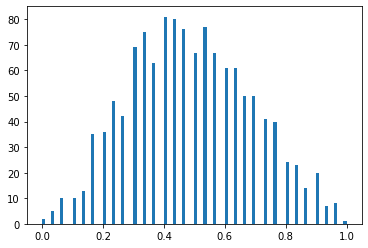

In [226]:
p = plt.hist(i, bins = 100)

In [8]:
companies_to_run = ["TSLA", "AAPL", "F", "RUN"]
price_hist = daily_price_df(companies_to_run)
target_return_df = return_df(price_hist["Adj Close"])

In [9]:
FF_info.head()

,mkt_cap,PB_ratio,ROE,Asset_growth
MMM,1.028818e+11,7.120830,0.46612,0.060122
ABT,2.090332e+11,6.184308,0.19658,0.068658
ABBV,1.959273e+11,15.586954,0.48855,0.689558
ABMD,1.544288e+10,11.810231,0.12818,0.228447
ACN,2.063766e+11,10.575364,0.31868,0.164441


In [10]:
FF_labeled_info = FF_assign_label(FF_info)

In [11]:
FF_labeled_info.head()

,mkt_cap,PB_ratio,ROE,Asset_growth,bookToMarket,Small_Big_Cap,HML_BP,RNW_ROE,ANC_investment
MMM,1.028818e+11,7.120830,0.46612,0.060122,0.140433,B,M,R,N
ABT,2.090332e+11,6.184308,0.19658,0.068658,0.161700,B,M,N,N
ABBV,1.959273e+11,15.586954,0.48855,0.689558,0.064156,B,L,R,A
ABMD,1.544288e+10,11.810231,0.12818,0.228447,0.084672,S,L,N,A
ACN,2.063766e+11,10.575364,0.31868,0.164441,0.094559,B,L,R,A


In [12]:
FF_subset_lists = FF_factor_classifier(FF_labeled_info)

In [14]:
#variables in this cell are useless, just showing what's in the output
small_low_group = FF_subset_lists[0]
small_low_group.head()

,mkt_cap,PB_ratio,ROE,Asset_growth,bookToMarket,Small_Big_Cap,HML_BP,RNW_ROE,ANC_investment
ABMD,1.544288e+10,11.810231,0.128180,0.228447,0.084672,S,L,N,A
ALLE,1.183572e+10,16.277687,0.636910,0.034443,0.061434,S,L,R,N
AAL,1.293669e+10,-1.883893,1.293869,0.033553,-0.530816,S,L,R,N
ABC,2.459272e+10,-29.289744,-1.707500,0.130268,-0.034142,S,L,W,N
APA,8.617784e+09,55.598608,2.151070,-0.296073,0.017986,S,L,R,C


In [15]:
FF_groups_return = FF_classes_return(sp500_return_df,FF_subset_lists)
FF_groups_return.head()

,Small_Low,Small_Mid,Small_High,Small_Weak,Small_Neutral_Profit,Small_Robust,Small_Cons,Small_Neutral_Invest,Small_Aggr,Big_Low,Big_Mid,Big_High,Big_Weak,Big_Neutral_Profit,Big_Robust,Big_Cons,Big_Neutral_Invest,Big_Aggr
Date,,,,,,,,,,,,,,,,,,
2016-11-17,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2016-11-18,-0.000072,-0.000276,0.000001,-0.000080,-0.000212,-0.000046,-0.000031,-0.000285,-0.000001,0.000224,-0.004087,-0.000021,0.0,-0.000868,-0.002094,-0.000276,-0.000239,-0.002946
2016-11-21,0.000374,0.000559,0.000286,0.000590,0.000479,0.000055,0.000155,0.000558,0.000491,0.002908,0.003068,0.000050,0.0,0.000141,0.004325,0.000245,-0.000084,0.005784
2016-11-22,-0.000631,0.000097,0.000781,0.000574,-0.000013,0.000012,-0.000145,0.000510,0.000006,0.000029,-0.000869,-0.000044,0.0,-0.001429,0.000044,0.000056,-0.000745,-0.000211
2016-11-23,0.000269,-0.000128,-0.000176,-0.000143,-0.000037,0.000020,-0.000073,-0.000153,0.000106,-0.000385,-0.001732,-0.000001,0.0,0.000688,-0.001717,0.000240,0.000415,-0.002359


In [16]:
FF_factors = FF_calc_factors(FF_groups_return, Rm, Rf)
FF_factors.head()

,SMB,HML,RMW,CMA,Rm-Rf
Date,,,,,
2016-11-18,0.000811,-0.000086,-0.001030,0.001320,-0.004240
2016-11-21,-0.000644,-0.001473,0.001895,-0.002937,0.005523
2016-11-22,0.000750,0.000669,-0.000259,0.000058,-0.000049
2016-11-23,0.000434,-0.000031,-0.000777,0.001210,-0.001456
2016-11-25,0.000813,0.000040,0.000077,-0.000297,0.001709


In [17]:
result = FF_regress(FF_factors, target_return_df, Rf)

TSLA

                            OLS Regression Results                            
Dep. Variable:         Return of TSLA   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     69.44
Date:                Tue, 16 Nov 2021   Prob (F-statistic):           3.49e-64
Time:                        20:30:23   Log-Likelihood:                 2494.0
No. Observations:                1257   AIC:                            -4976.
Df Residuals:                    1251   BIC:                            -4945.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.764   

In [ ]:
1. FRED SECTOR DATA, CBO PROJECTION
2. 